In [21]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Cascade Classifiers 로드__

In [12]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontface.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
glass_cascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')

__advanced_eye_detect 함수 정의__

In [13]:
def advanced_eye_detect(img,cascade,info):
    
    ret_val=None
    
    img_gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    eyes =cascade.detectMultiScale(img_gray,1.1,4)
    
    if (len(eyes)==0) or (eyes.shape[0]<2):
        
        if info == 'normal':
            return advanced_eye_detect(img,glass_cascade,'glasses')
        elif info == 'glasses':
            return ret_val
        
    ret_val = eyes
    return ret_val

In [ ]:
faces = face_cascade.detectMultiScale(gray) #사진정보,정밀도,얼굴 사이의 최소간격
for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2) #cv2.rectangle(img, start, end, color, thickness)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img2[y:y+h, x:x+w]
    eyes =eye_cascade.detectMultiScale(roi_gray,1.1,4)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
cv2.imshow('img',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

__get_aligned_ROI 함수 정의__

In [52]:
def get_aligned_ROI(img , eyes , early_stop=False):
    print(f'len : {len(eyes)}')
    eye_1 , eye_2 = eyes

    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
        
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    
    left_eye_x , left_eye_y = left_eye_center 
    right_eye_x , right_eye_y = right_eye_center

    
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    
    if early_stop:
        return left_eye_x , left_eye_y , np.sqrt(delta_x**2 + delta_y**2)
    
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi
    
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h))
    
    rotated_eyes =eye_cascade.detectMultiScale(rotated_img,1.1,4)
    rotated_eyes
    
    
    return rotated_eyes , rotated_img

__메인 코드__

len : 2


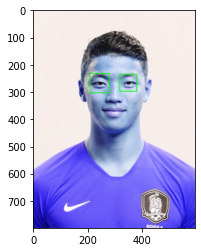

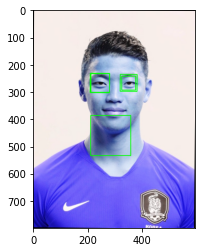

In [60]:
import os

#img_path = "전체 사진이 모여있는 폴더 경로명"
img_path = "C:/img_sample/2/"

files = os.listdir(img_path)
image_files = [file for file in files if file.endswith(".jpg")]
mask_area=[]
for file in image_files:
    
    image=cv2.imread(img_path+file)
    
    if image.shape[0]<400 or image.shape[1]<400 :
        w,h,c = image.shape
        image = cv2.resize(image,(h*2,w*2))
    
    eyes = advanced_eye_detect(image,eye_cascade,'normal')
    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(image,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    plt.figure()
    plt.imshow(image)
    
    if not len(eyes):
        print(file)
        print('Detection Failed : not human or invalid image')
        continue
        
    rotated_eyes , rotated_images = get_aligned_ROI(image,eyes)
    
    for (ex,ey,ew,eh) in rotated_eyes:
        cv2.rectangle(rotated_images,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    plt.figure()
    plt.imshow(rotated_images)
    break
    pivot_x , pivot_y , L = get_aligned_ROI(rotated_images,rotated_eyes , early_stop=True)
    
    xpad_L , xpad_R = int(0.6*L) , int(1.6*L)
    ypad_U , ypad_D = int(0.6*L) , int(1.8*L)
    
    ROI = image[pivot_y-ypad_U:pivot_y+ypad_D,pivot_x-xpad_L:pivot_x+xpad_R]
    ROI_resized = cv2.resize(ROI,(120,140))
    mask_area.append(ROI_resized[50:140,0:120])

In [58]:
rotated_eyes

array([[213, 234,  67,  67],
       [298, 224,  96,  96],
       [325, 243,  53,  53]], dtype=int32)

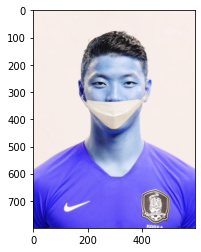

In [49]:
plt.imshow(image)

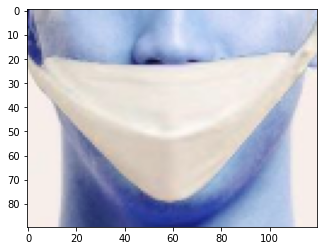

In [48]:
plt.imshow(mask_area[0])